In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [2]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [3]:
# df = pd.read_csv('6dfgs.csv', delimiter='|')

df = pd.read_csv('6dFGSv_recal_bar.200912', delimiter='|')


df = df.rename(columns=lambda x: x.strip())
df = df.set_index('PGC')

df = df.rename(columns={"1PGC": "PGC1"})

print(len(df))

ln10 = np.log(10.)
df['DM_6dfgs']  = (5*np.log10(df["D75"])+25.)
df['eDM_6dfgs'] = 5.*df["feD"]/ln10
df_6dfgs = df.rename(columns={"Nest": "Nest_6dfgs"})
df_6dfgs = df_6dfgs.rename(columns={"Vcmb": "Vcmb_6dfgs"})
df_6dfgs = df_6dfgs.rename(columns={"PGC1": "PGC1_6dfgs"})

df_6dfgs  = df_6dfgs[df_6dfgs['rej']==0]

df_6dfgs.head()

8885


,rej,PGC1_6dfgs,Nest_6dfgs,Name,Vcmb_6dfgs,Vgp,D75,D100,feD,DzDh,eDz,skew,RA,DE,Vg,Gp,DM_6dfgs,eDM_6dfgs
PGC,,,,,,,,,,,,,,,,,,
64,0,72642,200033,g0000523-355037,15324,14646,222.3,166.7,0.29,-0.034659,0.110224,0.010894,0.2181,-35.8437,14646,1261,36.734697,0.629727
66,0,72642,200033,g0000532-355911,14725,14646,191.0,143.2,0.27,0.030506,0.103811,-0.028422,0.2216,-35.9863,14646,1261,36.405167,0.586298
114,0,72642,200033,g0001341-361900,14397,14397,133.6,100.2,0.27,0.177860,0.105257,-0.103135,0.3923,-36.3167,14397,-1,35.629032,0.586298
115,0,115,0,g0001453-042049,14005,14005,188.5,141.4,0.27,0.015661,0.103465,-0.020551,0.4387,-4.3469,14005,-1,36.376557,0.586298
123,0,123,205549,g0001361-144455,10966,10966,160.2,120.1,0.26,-0.023948,0.099643,0.003134,0.4002,-14.7487,10966,-1,36.023313,0.564583


In [4]:
len(df_6dfgs)

7112

In [5]:
### Only DM_fp_sdss is taken from this catalo, since Brent has made 
# his updated in the All CF4 FP Samples file in EDD

# df = pd.read_csv('FP_sdss_pub.EDDhelper.csv', delimiter='|')
# df = df.rename(columns=lambda x: x.strip())
# df_EDD = df.set_index('PGC')

# df_EDD.head()

In [6]:
# df = pd.read_csv('FP_sdss_v3.csv', delimiter='|')
# df = pd.read_csv('FP_sdss_pub.csv', delimiter='|')
# df = pd.read_csv('FP_sdss_pub.220521.csv', delimiter='|')

df = pd.read_csv('sdss_fp_distances_pub_bar.220616', delimiter='|')

df_fpsdss = df.rename(columns=lambda x: x.strip())
df_fpsdss = df_fpsdss.set_index('PGC')

ln10 = np.log(10.)
df_fpsdss = df_fpsdss.rename(columns={"Nest": "Nest_fpsdss"})
df_fpsdss = df_fpsdss.rename(columns={"czcmb": "Vcmb_fpsdss"})
df_fpsdss = df_fpsdss.rename(columns={"1PGC": "PGC1_fpsdss"})

# Dc = Dist / Dist_fit
# Dist_fid = cz/H0  , H0 = 75

# 
# df_fpsdss["eDM_fpsdss"]

# logDist = df_fpsdss.logDc + np.log10(df_fpsdss.Vcmb_fpsdss/75.)
logDist = np.log10(df_fpsdss.D100/0.75)

df_fpsdss["DM_fpsdss"] = 5. * logDist + 25.
df_fpsdss["eDM_fpsdss"] = 5. * df_fpsdss.elogDc

print(len(df_fpsdss))

# df_fpsdss = df_fpsdss.join(df_EDD[["DM_fpsdss", "eDM_fpsdss"]], how="inner")

# df_fpsdss["DM_fpsdss"] = df_fpsdss.apply(lambda x: x["DM_fpsdss"] if x["DM_fpsdss"]>0 else np.nan, axis=1)
# df_fpsdss["eDM_fpsdss"] = df_fpsdss.apply(lambda x: x["eDM_fpsdss"] if x["DM_fpsdss"]>0 else np.nan, axis=1)

print(len(df_fpsdss))

df_fpsdss.head()

34059
34059


,D100,logDc,elogDc,skewc,logD,elogD,skew,czh,eczh,Vcmb_fpsdss,...,er,s,es,i,ei,objid,specid,plate,DM_fpsdss,eDM_fpsdss
PGC,,,,,,,,,,,,,,,,,,,,,
20919,187.3,0.040675,0.091698,-0.541032,0.038002,0.099509,-0.586469,16046,4,16184,...,2.65845,0.00873,2.46123,0.00775,1.0000,1237663547968323716,1951253584033114112,1733,36.987383,0.458490
21014,22.9,-0.156026,0.099438,0.076115,-0.147828,0.101547,0.097144,3131,2,3250,...,2.69511,0.00643,2.30353,0.00511,0.3231,1237663917871988832,2099918005914855936,1865,32.423871,0.497190
21072,166.8,0.025511,0.091508,-0.538911,0.022862,0.099260,-0.586179,14848,4,14984,...,2.63590,0.00767,2.47846,0.00755,1.0000,1237663531326243079,1951295365474969600,1733,36.735674,0.457540
21226,186.0,0.034595,0.097532,-0.675872,0.029237,0.099405,-0.584496,16126,2,16290,...,2.73040,0.00696,2.44156,0.00485,1.0000,1237653588476952852,609190772427745280,541,36.972258,0.487660
21473,117.8,-0.023480,0.099913,-0.619854,-0.026961,0.099046,-0.583037,11785,4,11962,...,2.12132,0.00742,2.28253,0.01174,1.0000,1237657595682029975,848939837200295808,754,35.980420,0.499565


In [8]:
df = pd.read_csv('all_cf2_fp.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df_cf2fp = df.set_index('PGC')

df_cf2fp = df_cf2fp.rename(columns={"1PGC": "PGC1"})


for suffix in ["smc","enr","far"]:
    df_cf2fp = df_cf2fp.rename(columns={"DM"+suffix: "DM_"+suffix})
    df_cf2fp["eDM_"+suffix] = 0.50
    df_cf2fp["DM_"+suffix][df_cf2fp["DM_"+suffix]==0] = np.nan
    df_cf2fp["eDM_"+suffix][df_cf2fp["DM_"+suffix].isna()] = np.nan
    df_cf2fp["PGC1_"+suffix] = df_cf2fp["PGC1"]
    df_cf2fp["Nest_"+suffix] = df_cf2fp["Nest"]
    df_cf2fp["Vcmb_"+suffix] = df_cf2fp["Vcmb"]


del df_cf2fp['PGC1']
del df_cf2fp['Nest']
del df_cf2fp['Vcmb']


<ipython-input-8-072314ad597c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cf2fp["DM_"+suffix][df_cf2fp["DM_"+suffix]==0] = np.nan
<ipython-input-8-072314ad597c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cf2fp["eDM_"+suffix][df_cf2fp["DM_"+suffix].isna()] = np.nan


In [9]:
len(df_6dfgs)

7112

In [10]:
how = 'outer'

df = df_6dfgs.join(df_fpsdss, lsuffix='_6dfgs', rsuffix='_fpsdss', how=how)

df = df.join(df_cf2fp, lsuffix='_fp', rsuffix='_cf2fp', how=how)

# df1 =  df[['PGC1_far','eDM_far']]
# df1g = df1.groupby('PGC1_far').count().rename(columns={"eDM_far":"N_far"})
# df1 = df1.reset_index().set_index('PGC1_far').join(df1g, lsuffix='_l', rsuffix='_r', how='left').reset_index().set_index('PGC')
# df1['eDM_far'] = df1['eDM_far']/np.sqrt(df1["N_far"])

# df['eDM_far'] = df1['eDM_far']
# df["N_far"] = df1["N_far"]


for col in df.columns:
    if col.split('_')[0]=='PGC1' and col!='PGC1_fpsdss':
        df['PGC1_fpsdss'] = df['PGC1_fpsdss'].fillna(df[col])
        
for col in df.columns:
    if col.split('_')[0]=='Nest' and col!='Nest_fpsdss':
        df['Nest_fpsdss'] = df['Nest_fpsdss'].fillna(df[col])



catalogs = ["fpsdss", "6dfgs", "smc", "enr", "far"]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, 'Nest_'+cat, "DM_"+cat, "eDM_"+cat, "Vcmb_"+cat]

df = df[ss]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['pgc1'] = df[ss].median(axis=1)
df = df[~df['pgc1'].isna()]


print(len(df))

df.head()

42254


,PGC1_fpsdss,Nest_fpsdss,DM_fpsdss,eDM_fpsdss,Vcmb_fpsdss,PGC1_6dfgs,Nest_6dfgs,DM_6dfgs,eDM_6dfgs,Vcmb_6dfgs,...,Nest_enr,DM_enr,eDM_enr,Vcmb_enr,PGC1_far,Nest_far,DM_far,eDM_far,Vcmb_far,pgc1
PGC,,,,,,,,,,,,,,,,,,,,,
64,72642.0,200033.0,NaN,NaN,NaN,72642.0,200033.0,36.734697,0.629727,15324.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0
66,72642.0,200033.0,NaN,NaN,NaN,72642.0,200033.0,36.405167,0.586298,14725.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0
114,72642.0,200033.0,NaN,NaN,NaN,72642.0,200033.0,35.629032,0.586298,14397.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0
115,115.0,0.0,NaN,NaN,NaN,115.0,0.0,36.376557,0.586298,14005.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.0
123,123.0,205549.0,NaN,NaN,NaN,123.0,205549.0,36.023313,0.564583,10966.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0


In [11]:
for cat in catalogs:
    df['Vmod_'+cat] = Vcmb2Vmod(df['Vcmb_'+cat])
    logD = (df['DM_'+cat]-25)/5.
    df['logH_'+cat] = np.log10(df['Vmod_'+cat]) - logD 
    
    print(cat, 10**df['logH_'+cat][df['Vmod_'+cat]>4000].median())

fpsdss 75.33571706276292
6dfgs 72.56945650701134
smc 76.73704799488011
enr 76.22256166035713
far 80.36152475092275


In [12]:
sigmaClips = {}

for i in range(1):
    for cat in catalogs:

        logH = df['logH_'+cat]
        med = logH[df['Vmod_'+cat]>4000].median()
        stdev = logH[df['Vmod_'+cat]>4000].std()
        
#         print cat, 10**med
        
        if not cat in sigmaClips:
                sigmaClips[cat] = []
        sigmaClips[cat] += list(df[(logH > med+3.5*stdev) | (logH < med-3.5*stdev)].index.values)
        df['DM_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan
        df['eDM_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan
        df['logH_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan


In [13]:
myDict = {}
myDict['fpsdss'] = 0

for cat in catalogs[1:]:

        delta = df['DM_fpsdss'] - df['DM_'+cat]

        stdev = delta.std()
        med   = delta.median()
        myDict[cat] = med


In [14]:
for cat in sigmaClips:
    print(cat, len(sigmaClips[cat]))

myDict

fpsdss 13
6dfgs 13
smc 1
enr 2
far 0


{'fpsdss': 0,
 '6dfgs': -0.14852318894814687,
 'smc': -0.0363671802307195,
 'enr': -0.05206342093248395,
 'far': 0.30770538361186084}

In [15]:
d = np.zeros(len(catalogs))
myDict = {}
for i, cat in enumerate(catalogs):
    myDict[cat] = d[i]

for cat in catalogs:
    df['w_'+cat] = 1./df['eDM_'+cat]**2
    df['xw_'+cat] = (df['DM_'+cat]+myDict[cat])*df['w_'+cat]

  
dg = df.groupby("pgc1").agg(["sum", "count"])

for cat in catalogs:
    dg['eDMg_'+cat] = np.sqrt(1./dg['w_'+cat]['sum'])
    dg['DMg_'+cat] = (dg['xw_'+cat]['sum'])/dg['w_'+cat]['sum']

ss = []
for cat in catalogs:
    dg['N_'+cat] = dg["DM_"+cat]['count']
    ss += ['N_'+cat, "DMg_"+cat, "eDMg_"+cat]

dg = dg[ss]
dg.replace([np.inf, -np.inf], np.nan, inplace=True)

dg.index = dg.index.astype('int')


ss = ['DMg_'+cat for cat in catalogs]+['eDMg_'+cat for cat in catalogs]
dg_ = dg[ss]

for cat in catalogs:
        dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2

<ipython-input-15-e20261dd2965>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2


In [16]:
def GfastChi2(dg, theta=None):
    
    if theta is None:
        d = np.zeros(len(catalogs))
    else:
        theta = np.asarray(theta)
        d = np.concatenate((np.zeros(1), theta[1:]))
    
    myDict = {}
    for i, cat in enumerate(catalogs):
        myDict[cat] = d[i]

    ###########################################################
        
    for cat in catalogs:
#         dg['gw_'+cat] = 1./dg['eDMg_'+cat]**2
        dg['gxw_'+cat] = (dg['DMg_'+cat]+myDict[cat])*dg['gw_'+cat]


    sx = ['gxw_'+cat for cat in catalogs]
    sw = ['gw_'+cat for cat in catalogs]
    
    ERRave2 = 1./dg[sw].sum(axis=1)
    ave = dg[sx].sum(axis=1)*ERRave2
    
    myDict[catalogs[0]] = theta[0]
    for cat in catalogs:
        dg['gxi2_'+cat] = ((dg['DMg_'+cat]+myDict[cat]-ave)**2)/(dg_['eDMg_'+cat]**2+ERRave2)


    sxi = ['gxi2_'+cat for cat in catalogs]    
    XI2 = dg[sxi].sum(axis=1)

    return XI2.sum()

In [17]:
t1 =  datetime.now()

print(GfastChi2(dg_, theta=range(len(catalogs))))

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

13894.874656890112
Execution time:
0:00:00.045288


In [18]:
len(dg_)

18798

In [19]:
len(df)

42254

In [20]:
def lnlike(theta):
    
    xi2 = GfastChi2(dg_, theta=theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    return 0.0


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

Execution time:
3:40:18.926434


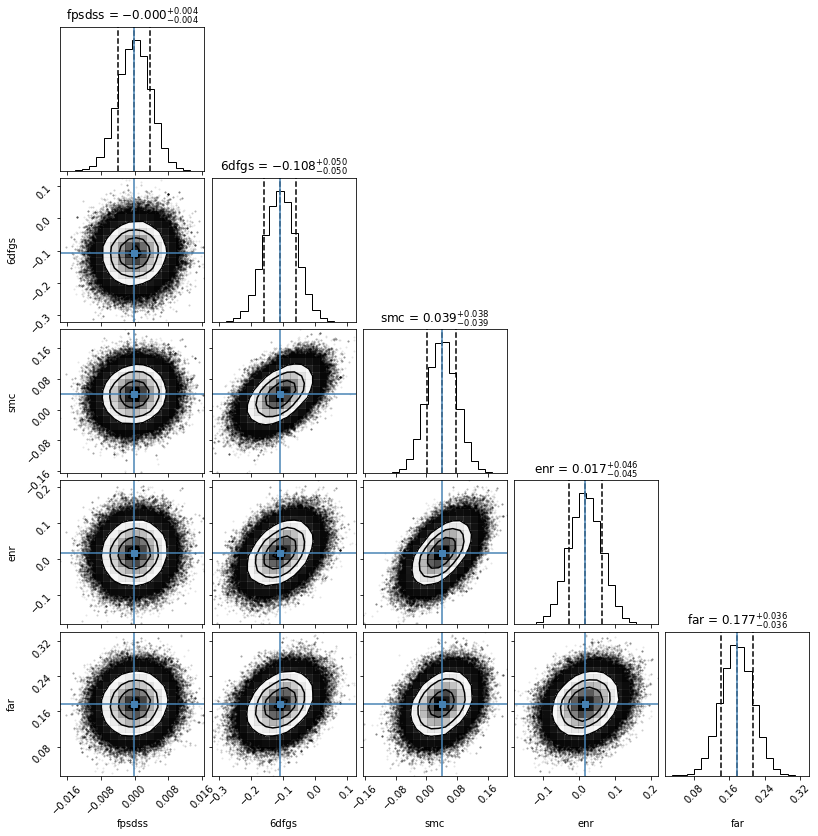

In [21]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = len(catalogs), 64

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 10000)
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]
fig = corner.corner(samples, labels=catalogs, 
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12}, 
                    title_fmt=".3f")

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

In [22]:
npzName = "CF4_FP_group.220521.EDDhelper.inv1.npz"
np.savez(npzName, samples)

In [23]:
npzName = "CF4_FP_group.220521.EDDhelper.inv1.npz"
npzfile = np.load(npzName)
print("npz attributes: ", npzfile.files)
NPZsamples = npzfile['arr_0']

npz attributes:  ['arr_0']


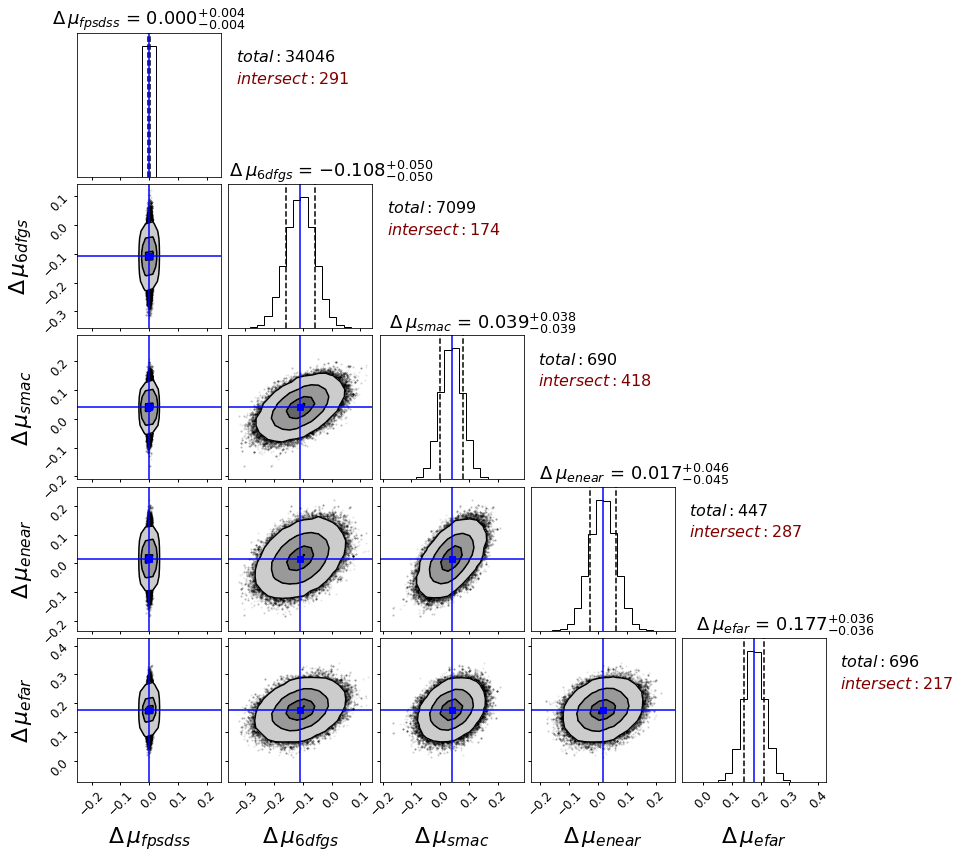

In [24]:
theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]

labels = ['           '+r'$\Delta\/ \mu_{'+cat+'}$' for cat in ["fpsdss", "6dfgs", "smac", "enear", "efar"]]

fig = corner.corner(samples, labels=labels, 
                    truths=truths, truth_color='blue',
                    levels=(1-np.exp(-1./8),1-np.exp(-0.5),1-np.exp(-0.5*4),1-np.exp(-0.5*9)),
                    show_titles=True, fill_contours=True, plot_density=True,
                    quantiles=[0.16, 0.84], 
                    scale_hist=False,space=0, 
                    title_kwargs={"fontsize": 18}, 
                    title_fmt=".3f",
                    range=[(t-0.25,t+0.25) for t in truths]
                   )


m = 0 
n_cat = len(catalogs)
i_cat = 0
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(50)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)    
    
    ### forcing the the title of the upper left corner panel to be zero
    title = ax.get_title().strip()
    if m==0:
        tl = title.split("=")
        left = tl[0]
        right = tl[1]
        nl = right.split("_")
        number = nl[0]
        error  = nl[1]
        title = left+'='+' ${0.000}_'+error
        ax.set_title(title)
        ax.title.set_fontsize(18)

    
    ax.tick_params(which='major', length=3, width=1., direction='out')
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = -0.1*Xlm[0]+1.1*Xlm[1]
    
    if m%(n_cat+1)==0:
        y0 = 0.2*Ylm[0]+0.80*Ylm[1]
        dx = df[['DM_'+catalogs[i_cat]]].dropna()
        ax.text(x0,y0, r"$total: $"+str(len(dx)), fontsize=16, color='k')
        
        y0 = 0.35*Ylm[0]+0.65*Ylm[1]
        other_DMs = ["DM_"+c for c in catalogs if c != catalogs[i_cat]]
        
        df["sumDM"] = df[other_DMs].sum(axis=1)
        df["sumDM"][df["sumDM"]==0] = np.nan
        
        dx = df[['sumDM', 'DM_'+catalogs[i_cat]]].dropna()       
        ax.text(x0,y0, r"$intersect: $"+str(len(dx)), fontsize=16, color='maroon')
        i_cat += 1


    m+=1

